#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [3]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  pred = w.T*X + w0
  loss_funk = np.log(1+ np.exp(-y[:,None] * pred))
  loss_res = loss_funk/X.shape[0] + gamma*np.abs(w).sum() + beta*(((np.array(w)**2).sum())**0.5)
  return loss_res.sum()

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''

    sigmoid = 1/(1 + np.exp(y * (X.dot(w)+w0)))
    grad_weights = (- X*y[:,None] * sigmoid[:,None] /X.shape[0]).sum(axis=0) + gamma*np.sign(w) + 2*beta*w
    grad_bias = -(y* sigmoid).sum() /X.shape[0]

    return grad_weights, grad_bias

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w, grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-1) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-1)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278] -0.20782319347690742


####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42, batch_size=128, epoch=100):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.batch_size = batch_size
        self.epochs= epoch

        self.losses = []
        self.weights = np.array([None])
        self.bias = np.array([None])

    def fit(self, X, y):
        np.random.seed(self.random_state)
        if (self.weights == None).all():
          self.weights = np.random.randn(X.shape[1])
        if (self.bias == None).all():
          self.bias = np.random.rand()

        iter = 0
        for epoch in range(self.epochs):
          X, y = shuffle(X, y)

          for batch in range(self.batch_size, X.shape[0], self.batch_size):
            iter += 1
            if iter%200 == 0:
              self.lr = self.lr *0.8
            X_batch = X[batch - self.batch_size: batch]
            y_batch = y[batch - self.batch_size: batch]
            self.losses.append(loss(X_batch, y_batch, self.weights, self.bias, self.gamma, self.beta))
            grad_weights, grad_bias = get_grad(X_batch, y_batch, self.weights, self.bias, self.gamma, self.beta)

            self.weights -=self.lr * grad_weights
            self.bias -= self.lr * grad_bias

            if (iter==self.max_iter) or (np.abs(grad_weights).max() <self.tolerance):
              return self

        return self

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        return ((self.predict_proba(X)>0.5) - 0.5) * 2


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        pred = X.dot(self.weights) + self.bias
        proba = 1 / (1 + np.exp(-pred))
        return proba

In [8]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [9]:
def plot_decision_boundary(model, X, y):
    first_class = X[y==1]
    x_first, y_first = first_class.T
    second_class = X[y!=1]
    x_second, y_second = second_class.T

    plt.scatter(x_first, y_first, c='#e377c2')
    plt.scatter(x_second, y_second, c = '#9467bd')

    x_line = np.arange(X.T[0].min(), X.T[0].max(), 2)
    k = model.weights
    b = model.bias
    y_line = (-x_line*k[0] - b)/k[1]
    plt.plot(x_line, y_line)


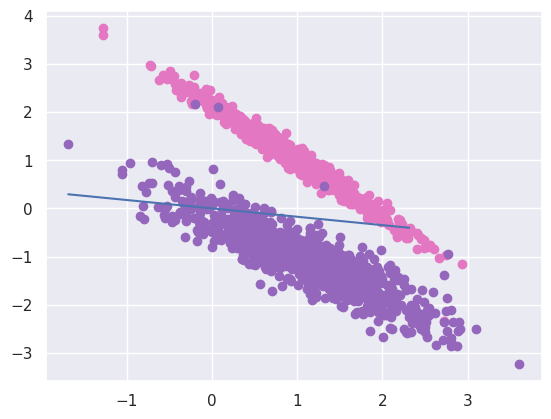

In [10]:
model = Logit(0, 0, epoch= 200, max_iter=10000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [11]:
def plot_loss_history(model):
    losses = model.losses
    plt.plot(np.arange(1, len(losses)+1), losses)


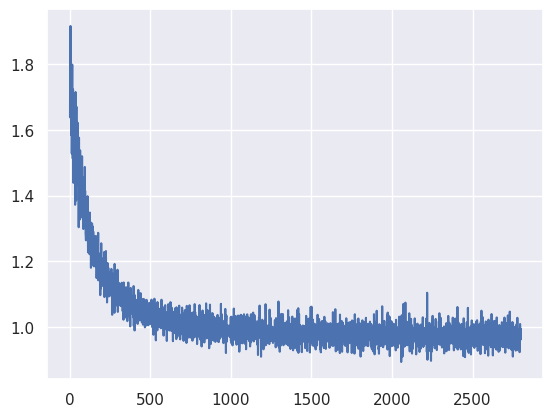

In [12]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

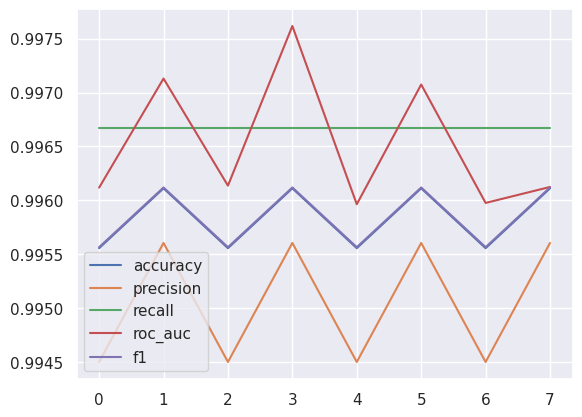

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':np.logspace(-1,2,4)}
metrics = [
    'accuracy',
    'precision',
    'recall',
    'roc_auc',
    'f1'
]
clf = GridSearchCV(SVC(), parameters, scoring=metrics, refit='roc_auc', cv=5)
clf.fit(X, y)
results = {x: clf.cv_results_[f'mean_test_{x}'] for x in metrics}
for i in results.keys():
  plt.plot(range(len(results[i])), list(results[i]), label=str(i))


plt.legend()
plt.show()

In [14]:
clf.best_params_

{'C': 1.0, 'kernel': 'rbf'}

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [15]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric_dist='euclidean', targets=None):
      self.n_neighbors = n_neighbors

      self.metrics_for_knn  = {
          'euclidean': euclidean_distances,
          'cosine': cosine_distances
      }
      self.metric_dist = metric_dist

      self.X = 0
      self.y = 0
      self.targets = targets

    def fit(self, X, y):
      self.X = X
      self.y = y
      if self.targets==None:
        self.targets = np.unique(y)

    def predict(self, X):
      return self.targets[np.argmax(self.predict_proba(X),axis=1)]

    def predict_proba(self, X):
      rasstoyanie = self.metrics_for_knn[self.metric_dist](self.X, X)
      blizhayshie = np.argsort(rasstoyanie, axis =0).T[:,:self.n_neighbors]
      means_bl = self.y[blizhayshie]
      result = np.zeros((X.shape[0], self.targets.shape[0]))
      for i in range(self.targets.shape[0]):
        result[:,i] += (means_bl==self.targets[i]).sum(axis=1) #сложность константная (нестрашно)
      return result/self.n_neighbors

In [16]:
from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_auc_score, f1_score

model = KNNClassifier()
X, y = shuffle(X, y)
split = int(X.shape[0]*0.8)

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model.fit(X_train, y_train)
prediction = model.predict(X_test)

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'roc_auc':roc_auc_score,
    'f1':f1_score
}

for metr in metrics:
  print(f'{metr}: {metrics[metr](y_test, prediction)}')

accuracy: 0.9972222222222222
precision: 0.9940476190476191
recall: 1.0
roc_auc: 0.9974093264248705
f1: 0.9970149253731343



## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df = pd.read_csv('/content/drive/MyDrive/DZ2.csv')
df.head(5)

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
target = 'Category'
dont_need = 'Id'

features = []
for cat in df.columns:
  if cat not in [target, dont_need]:
    features.append(cat)

X,y = df[features], df[target]
X_train, y_train = X[:50000], y[:50000]
X_test, y_test = X[50000:], y[50000:]

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

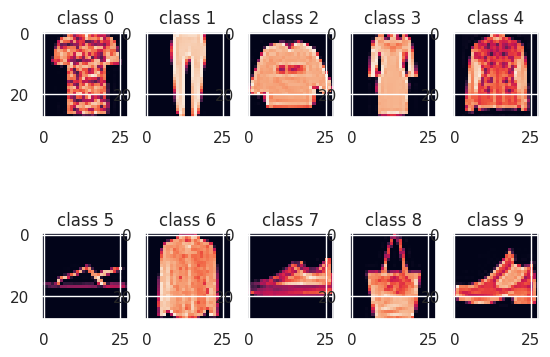

In [20]:
categories = np.unique(y_train)
fig, axs = plt.subplots(2,5)
for i,cat in enumerate (categories):
  axs[i//5, i%5].imshow(X_train [y_train.to_numpy()==i].iloc[0].to_numpy().reshape(28,28))
  axs[i//5, i%5].set_title(f'class {cat}')

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

stand_preprocessor = StandardScaler()
min_max_preprocessor = MinMaxScaler()
X_train_stand = stand_preprocessor.fit_transform(X_train)
X_train_min_max = min_max_preprocessor.fit_transform(X_train)

X_test_stand = stand_preprocessor.transform(X_test)
X_test_min_max = min_max_preprocessor.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

***Логистическая регрессия обученная на нормированных данных***

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [24]:
logreg_params = [{
    'penalty' : ['l2', 'l1'],  #l2 регуляризация , конечно, очень хороша, но мы работаем с картинками, и приемущество l1 которое может нам помочь - она зануляет признаки которые не имеют большого влияния (для картинок это хорошо формирует паттерны и мы видим что ищет модель, а это легко интерпритируемо)
    'C': np.logspace(-1,0,2),  #классика
}]
clf_logreg = LogisticRegression(solver='saga',max_iter=30) #очень долго тренить с liblinear onevsall и saga с большим колличеством итераций тоже долго

gs_cv_logreg = GridSearchCV( clf_logreg, param_grid=logreg_params, scoring='accuracy', cv=5)
gs_cv_logreg.fit(X_train_stand, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=30, solver='saga'),
             param_grid=[{'C': array([0.1, 1. ]), 'penalty': ['l2', 'l1']}],
             scoring='accuracy')

In [25]:
clf_logreg_best = gs_cv_logreg.best_estimator_
predictions_logreg = clf_logreg_best.predict(X_test_stand)

print(f'beas_accuracy:{accuracy_score(y_test, predictions_logreg)}')

beas_accuracy:0.8496


In [26]:
gs_cv_logreg.best_params_

{'C': 0.1, 'penalty': 'l2'}

***Логистическая регрессия обученная на данных, обработанных minmax***

In [ ]:
clf_logreg_min_max = LogisticRegression(solver='saga',max_iter=30)
gs_cv_logreg_min_max = GridSearchCV(clf_logreg_min_max, param_grid=logreg_params, scoring='accuracy', cv=5)
gs_cv_logreg_min_max.fit(X_train_min_max, y_train)

In [ ]:
clf_logreg_best_min_max = gs_cv_logreg_min_max.best_estimator_
predictions_logreg_min_max = clf_logreg_best_min_max.predict(X_test_min_max)

print(f'beas_accuracy:{accuracy_score(y_test, predictions_logreg_min_max)}')

***KNN на нормированных данных***

In [ ]:
clf_knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': [3, 5 ,7],
    'metric': ['minkowski', 'cosine']
}

gs_cv_knn = GridSearchCV(clf_knn, param_grid=params_knn, scoring='accuracy', cv=10)
gs_cv_knn.fit(X_train_stand, y_train)


In [ ]:
clf_knn_best = gs_cv_knn.best_estimator_
predictions_knn = clf_knn_best.predict(X_test_stand)

print(f'beas_accuracy:{accuracy_score(y_test, predictions_knn)}')

beas_accuracy:0.8621


***KNN на min_max обработанных данных***

In [ ]:
clf_knn_min_max = KNeighborsClassifier()

gs_cv_knn_min_max = GridSearchCV(clf_knn_min_max, param_grid=params_knn, scoring='accuracy', cv=5)
gs_cv_knn_min_max.fit(X_train_min_max, y_train)

clf_knn_best_min_max = gs_cv_knn_min_max.best_estimator_
predictions_knn_min_max = clf_knn_best_min_max.predict(X_test_min_max)

print(f'beas_accuracy:{accuracy_score(y_test, predictions_knn_min_max)}')

beas_accuracy:0.8623


У нас маленькая сходимость из-за маленьких max_iter, но скорее всего регрессия их за потери пространственной связи между пикселями мы потеряем много смысла, а КНН найдет ближайшие картинке по пикселям, и эта информация лучше сохранит пространственное строение изображения

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

***Модель, вероятность предсказаний меток классов которой будет всегда 1/2, поскольку она построит разделяющую поверхность которая проходит через все эти точки и содержащая их всех. Соответсвенно любая точка в тестовой выборке окажется в одной из полуплоскостей (которые заданы случайно)***

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

In [29]:
clf_onevsone = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=20, C= 0.1, penalty= 'l2'))
clf_onevsone.fit(X_train_stand, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, max_iter=20,
                                                 solver='liblinear'))

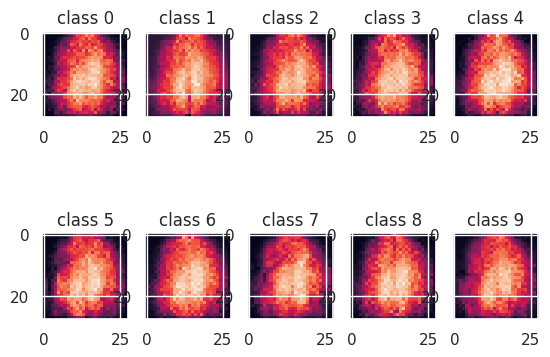

In [30]:
fig, axs = plt.subplots(2,5)
for i,cat in enumerate (categories):
  axs[i//5, i%5].imshow(stand_preprocessor.inverse_transform(clf_onevsone.estimators_[i].coef_).reshape(28,28))
  axs[i//5, i%5].set_title(f'class {cat}')

Малая грубина не дает яркой картинки паттернов

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [38]:
!pip install catboost
from catboost import CatBoostClassifier

clf_cat_boost = CatBoostClassifier(iterations=150)
clf_cat_boost.fit(X_train_stand, y_train)
pred = clf_cat_boost.predict(X_test_stand)
print(f'beas_accuracy:{accuracy_score(y_test, pred)}')

Learning rate set to 0.479925
0:	learn: 1.1795241	total: 7.92s	remaining: 19m 39s
1:	learn: 0.9315319	total: 13.4s	remaining: 16m 31s
2:	learn: 0.8168104	total: 22.4s	remaining: 18m 19s
3:	learn: 0.7353139	total: 29.3s	remaining: 17m 49s
4:	learn: 0.6837516	total: 34.7s	remaining: 16m 46s
5:	learn: 0.6320688	total: 42.8s	remaining: 17m 7s
6:	learn: 0.5971958	total: 48.3s	remaining: 16m 27s
7:	learn: 0.5728303	total: 55.7s	remaining: 16m 29s
8:	learn: 0.5534922	total: 1m 1s	remaining: 16m 10s
9:	learn: 0.5416177	total: 1m 7s	remaining: 15m 45s
10:	learn: 0.5260922	total: 1m 15s	remaining: 15m 51s
11:	learn: 0.5126380	total: 1m 20s	remaining: 15m 30s
12:	learn: 0.5010265	total: 1m 28s	remaining: 15m 34s
13:	learn: 0.4868553	total: 1m 34s	remaining: 15m 14s
14:	learn: 0.4762904	total: 1m 40s	remaining: 15m 2s
15:	learn: 0.4664400	total: 1m 47s	remaining: 15m 1s
16:	learn: 0.4537187	total: 1m 53s	remaining: 14m 45s
17:	learn: 0.4457865	total: 2m 1s	remaining: 14m 47s
18:	learn: 0.4412101	t